## Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.linalg import norm
from pysal.lib.weights import Queen
from spint.gravity import Gravity, Production
from spopt import MaxPHeuristic, RegionKMeansHeuristic, WardSpatial, Skater

/home/thoffman/anaconda3/envs/gds/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
def isCA_cts(x):
    # Vectorized evaluation if row is a CA to CA flow in SafeGraph data
    return [el[0] == '6' and len(el) == 10 for el in x]

In [4]:
ct_daily = pd.read_csv('../data/daily_ct2ct_08_10.csv', 
    converters={'geoid_o' : lambda x: str(x), 'geoid_d' : lambda x: str(x), 'visitor_flows' : lambda x: int(float(x)), 'pop_flows' : lambda x: int(float(x))}, 
    usecols=['geoid_o', 'geoid_d', 'lng_o', 'lat_o', 'lng_d', 'lat_d', 'visitor_flows', 'pop_flows'])
ct_daily = ct_daily[np.logical_and(isCA_cts(ct_daily['geoid_o']), isCA_cts(ct_daily['geoid_d']))]
ct_daily['geoid_o'] = '0' + ct_daily['geoid_o']
ct_daily['geoid_d'] = '0' + ct_daily['geoid_d']

CAtracts = gpd.read_file('../data/CAtract_level_data.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

In [6]:
# DO NOT RUN -- DEPRECATED -- current code just uses counties and flows dataframes
CAtdata = CAtracts.join(ct_daily.set_index('geoid_o'), on='GEOID')

## Tract level regionalization

In [21]:
# Convert cols to float
CAtracts['B00001_001E'] = pd.to_numeric(CAtracts['B00001_001E'])
CAtracts['B02001_002E'] = pd.to_numeric(CAtracts['B02001_002E'])
CAtracts['B07411_001E'] = pd.to_numeric(CAtracts['B07411_001E'])

In [22]:
np.isnan(CAtracts[['B00001_001E', 'B02001_002E', 'B07411_001E']].values)

array([[False, False,  True],
       [False, False,  True],
       [False, False,  True],
       ...,
       [False, False,  True],
       [False, False,  True],
       [False, False,  True]])

In [23]:
Wt = Queen.from_dataframe(CAtracts)

/home/thoffman/anaconda3/envs/gds/lib/python3.6/site-packages/pysal/lib/weights/contiguity.py:184: UserWarning: There is one disconnected observation (no neighbors).
Island id: 4199
  W.__init__(self, neighbors, ids=ids, **kw)


In [24]:
attrs = ['B02001_002E']  # 'B00001_001E' : total pop, 'B02001_002E' : total white people, 'B07411_001E' : median income
ward_model = WardSpatial(CAtracts, Wt, attrs, n_clusters=12)
ward_model.solve()
CAtracts['ward_labels'] = ward_model.labels_

/home/thoffman/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/cluster/_agglomerative.py:247: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


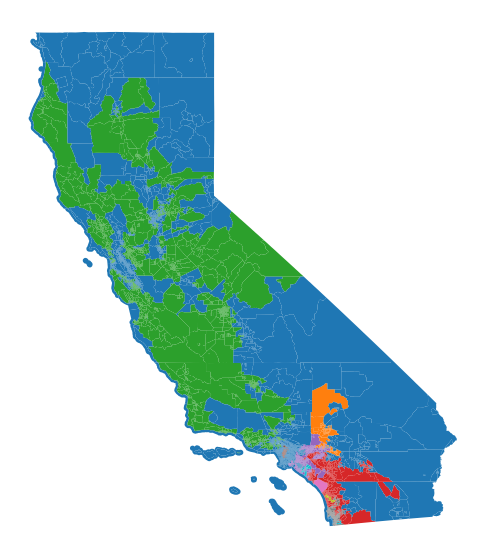

In [25]:
# Plot Ward linkage spatial clustering
fig, ax = plt.subplots(figsize=(10,10))
CAtracts.plot(column='ward_labels', categorical=True, edgecolor='none', ax=ax)
plt.axis('off')
plt.savefig('cat_ward.png')

### Aggregate tract-level data by the regionalization and run Gravity model

In [26]:
regtdata = CAtracts.dissolve(by='ward_labels', aggfunc='mean')

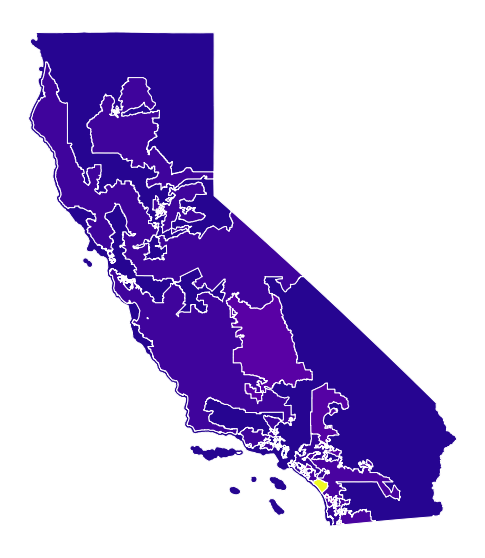

In [27]:
_, ax = plt.subplots(figsize=(10,10))
regtdata.plot(column='B02001_002E', ec='w', cmap='plasma', ax=ax)
plt.axis('off')
plt.savefig('cat_ward_pop.png')

#### Manually aggregate flows

In [33]:
CAtdata = ct_daily.join(CAtracts.set_index('GEOID'), on='geoid_o')

In [36]:
# function to determine what region a census tract is in
def regionof(geoid): 
    return CAtdata.loc[CAtdata['geoid_o'] == geoid, 'ward_labels'].iloc[0]

In [37]:
# Manually aggregate flows -- started at 9am 11/18 and didn't finish by 12:30pm

flows = np.zeros((CAtdata['ward_labels'].unique().shape[0], CAtdata['ward_labels'].unique().shape[0]))
for o in range(flows.shape[0]):
    # Locate all flows origininating in region i and going to different regions    
    for r in CAtdata.loc[CAtdata['ward_labels'] == o].iterrows():
        dest = regionof(r[1]['geoid_o'])
        if o != dest: flows[o, dest] += r[1]['pop_flows']

KeyboardInterrupt: 

#### Fit Gravity model on the tracts

In [28]:
# use aggregated centroids to create costs in Euclidean distances (do this with a spatial weight?)
coords = np.hstack((regtdata.centroid.x.values.reshape(-1, 1), regtdata.centroid.y.values.reshape(-1, 1)))
o_coords = np.repeat(coords, coords.shape[0], axis=0)
d_coords = np.tile(coords, (coords.shape[0], 1))
cost = norm(o_coords - d_coords, axis=1)

In [29]:
# set o_vars and d_vars based on aggregated matrix
basevars = regtdata[['B00001_001E', 'B02001_002E']].astype(int).values
o_vars = np.repeat(basevars, basevars.shape[0], axis=0)
d_vars = np.tile(basevars, (basevars.shape[0], 1))

In [ ]:
model = Gravity(iflows, o_vars, d_vars, cost, 'exp')

In [ ]:
model.params

In [ ]:
model.AIC